In [56]:
import warnings
import os
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.linalg import norm
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from joblib import Parallel, delayed

In [ ]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

np.seterr(all='ignore')

class DevNull:
    def write(self, msg):
        pass
    def flush(self):
        pass

sys.stderr = DevNull()


In [58]:
class VQSVDQiskit:
    def __init__(self,
                 matrix: np.ndarray,
                 weights: np.ndarray,
                 num_qubits: int,
                 depth: int,
                 rank: int,
                 lr: float,
                 iterations: int,
                 seed: int):
        """
        Qiskit-based Variational Quantum SVD using ADAM and parameter-shift.
        """
        self.rank = rank
        self.num_qubits = num_qubits
        self.depth = depth
        self.iterations = iterations
        self.lr = lr
        np.random.seed(seed)

        self.param_shape = (depth, 2, num_qubits)
        self.theta = np.random.uniform(0, 2 * np.pi, size=self.param_shape)
        self.phi = np.random.uniform(0, 2 * np.pi, size=self.param_shape)

        self.M = matrix.astype(complex)
        self.weights = weights.astype(complex)
        self.backend = AerSimulator(method="statevector")

        self.U = self._get_unitary(self.theta)
        self.V = self._get_unitary(self.phi)

        self.history_losses = []
        self.history_svals = []

    def _ansatz(self, params: np.ndarray) -> QuantumCircuit:
        qc = QuantumCircuit(self.num_qubits)
        for d in range(self.depth):
            for q in range(self.num_qubits):
                qc.ry(params[d, 0, q], q)
                qc.rz(params[d, 1, q], q)
            for q in range(self.num_qubits - 1):
                qc.cx(q, q + 1)
        return qc

    def _get_unitary(self, params: np.ndarray) -> np.ndarray:
        dim = 2 ** self.num_qubits
        columns = []

        for idx in range(dim):
            qc = QuantumCircuit(self.num_qubits)
            bstr = format(idx, f"0{self.num_qubits}b")[::-1]
            for q, bit in enumerate(bstr):
                if bit == '1':
                    qc.x(q)
            qc = qc.compose(self._ansatz(params))
            qc.save_statevector()
            result = self.backend.run(qc).result()
            vec = result.get_statevector(0)
            columns.append(vec)

        return np.column_stack(columns)

    def get_U(self) -> np.ndarray:
        return self.U

    def get_V(self) -> np.ndarray:
        return self.V

    def _loss_and_svals(self, flat_vars: np.ndarray):
        chunk = self.depth * 2 * self.num_qubits
        theta = flat_vars[:chunk].reshape(self.param_shape)
        phi = flat_vars[chunk:].reshape(self.param_shape)

        U = self._get_unitary(theta)
        V = self._get_unitary(phi)

        self.U = U
        self.V = V

        product = U.conj().T @ self.M @ V
        svals = [np.real(product[i, i]) for i in range(self.rank)]
        loss = -np.sum(self.weights[:self.rank] * svals)

        return float(np.real(loss)), svals

    def train_with_adam_numpy(self, beta1=0.9, beta2=0.999, epsilon=1e-8, n_jobs=8):
        chunk = self.depth * 2 * self.num_qubits
        flat_vars = np.concatenate([self.theta.flatten(), self.phi.flatten()])

        m = np.zeros_like(flat_vars)
        v = np.zeros_like(flat_vars)

        self.history_losses = []
        self.history_svals = []

        alpha = self.lr

        def loss_only(x):
            loss, _ = self._loss_and_svals(x)
            return loss

        def numerical_gradient_parallel(f, x, eps=1e-5):
            fx = f(x)

            def grad_i(i):
                x_step = np.array(x)
                x_step[i] += eps
                fxh = f(x_step)
                return (fxh - fx) / eps

            grad = Parallel(n_jobs=n_jobs)(
                delayed(grad_i)(i) for i in range(len(x))
            )
            return np.array(grad)

        for t in range(1, self.iterations + 1):
            grad = numerical_gradient_parallel(loss_only, flat_vars)

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad ** 2)

            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)

            flat_vars -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)

            loss, svals = self._loss_and_svals(flat_vars)
            self.history_losses.append(loss)
            self.history_svals.append(svals)

            if t % 10 == 0 or t == 1 or t == self.iterations:
                print(f"Iteration {t}/{self.iterations} | Loss: {loss:.6f}")

        # Update internal parameters
        self.theta = flat_vars[:chunk].reshape(self.param_shape)
        self.phi = flat_vars[chunk:].reshape(self.param_shape)
        self.U = self._get_unitary(self.theta)
        self.V = self._get_unitary(self.phi)

        return self.history_losses, self.history_svals


    def frobenius_errors(self,
                         M_true: np.ndarray,
                         M_approx: np.ndarray,
                         U_learnt: np.ndarray,
                         svals_list: list,
                         V_dagger_learnt: np.ndarray,
                         rank: int):
        U_true, S_true, Vh_true = np.linalg.svd(M_true, full_matrices=True)
        svals = np.array(svals_list[-1], dtype=float)

        err_local = []
        err_subfull = []
        err_svd = []

        for i in range(1, rank + 1):
            U_blk = U_true[:, :i]
            S_blk = np.diag(S_true[:i])
            V_blk = Vh_true[:i, :]
            lowrank = U_blk @ S_blk @ V_blk

            U_est = U_learnt[:, :i]
            S_est = np.diag(svals[:i])
            V_est = V_dagger_learnt[:i, :]
            recons = U_est @ S_est @ V_est

            err_local.append(norm(lowrank - recons, ord="fro"))
            err_subfull.append(norm(M_approx - recons, ord="fro"))
            err_svd.append(norm(M_approx - lowrank, ord="fro"))

        return err_local, err_subfull, err_svd


In [59]:
class LossPlotQiskit:
    def __init__(self, save_path: str = "results/"):
        """
        Initializes the plotting utility and creates the output directory.
        """
        os.makedirs(save_path, exist_ok=True)
        self.save_path = save_path

    def plot_loss_curve(self, losses: list):
        """
        Plots the loss curve over iterations and saves it.
        """
        plt.figure()
        plt.plot(range(1, len(losses) + 1), losses, "b-", label="Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title("VQSVD (Qiskit) Loss Curve")
        plt.grid(True)
        plt.legend()
        filepath = os.path.join(self.save_path, "qiskit_loss_curve.png")
        plt.savefig(filepath)
        print(f"Loss curve saved as {filepath}")
        plt.show()
        plt.close()

    def plot_singular_value_comparison(self, rank: int, vqsvd: list, svd: list):
        """
        Compares singular value reconstruction errors for VQSVD and classical SVD.
        """
        plt.figure()
        x = list(range(1, rank + 1))
        plt.plot(x, vqsvd, "o-.", label="VQSVD Reconstruction")
        plt.plot(x, svd, "^--", label="SVD Reconstruction")
        plt.xlabel("Used Rank")
        plt.ylabel("Norm Distance")
        plt.title("Singular Value Reconstruction Comparison")
        plt.grid(True)
        plt.legend()
        filepath = os.path.join(self.save_path, "qiskit_singular_value_comparasion.png")
        plt.savefig(filepath)
        print(f"Singular value errors saved as {filepath}")
        plt.show()
        plt.close()

    def plot_matrix_image(self, matrix: np.ndarray, title: str = "Reconstructed Matrix"):
        """
        Displays and saves the matrix as a grayscale image.
        """
        plt.figure()
        plt.imshow(np.real(matrix), cmap="gray")
        plt.title(title)
        plt.colorbar()
        filepath = os.path.join(self.save_path, "qiskit_reconstruction_matrix.png")
        plt.savefig(filepath)
        print(f"Reconstructed matrix image saved as {filepath}")
        plt.show()
        plt.close()


In [60]:
class MatrixGeneratorQiskit:
    def __init__(self, num_qubits: int):
        """
        Initializes the generator with a specified number of qubits.
        """
        self.num_qubits = num_qubits

    def from_image(self, image_path: str) -> np.ndarray:
        """
        Loads a grayscale image of size 2^n × 2^n and normalizes its pixel values to [0, 1].
        Returns a complex matrix.
        """
        img = Image.open(image_path).convert("L")
        matrix = np.array(img, dtype=float) / 255.0
        return matrix.astype(complex)

    def generate_random_matrix(self) -> np.ndarray:
        """
        Generates a random complex matrix of size 2^n × 2^n.
        """
        dim = 2 ** self.num_qubits
        real = np.random.randint(0, 10, size=(dim, dim))
        imag = np.random.randint(0, 10, size=(dim, dim))
        return (real + 1j * imag).astype(complex)


Starting training… (this may take a while)
Iteration 1/200 | Loss: -127.080709
Iteration 10/200 | Loss: -456.252622
Iteration 20/200 | Loss: -511.307948
Iteration 30/200 | Loss: -544.937125
Iteration 40/200 | Loss: -564.757804
Iteration 50/200 | Loss: -579.304916
Iteration 60/200 | Loss: -589.012722
Iteration 70/200 | Loss: -596.290733
Iteration 80/200 | Loss: -601.557764
Iteration 90/200 | Loss: -605.203840
Iteration 100/200 | Loss: -607.738831
Iteration 110/200 | Loss: -609.472027
Iteration 120/200 | Loss: -610.745502
Iteration 130/200 | Loss: -611.733408
Iteration 140/200 | Loss: -612.510178
Iteration 150/200 | Loss: -612.649256
Iteration 160/200 | Loss: -613.623976
Iteration 170/200 | Loss: -613.972271
Iteration 180/200 | Loss: -614.427366
Iteration 190/200 | Loss: -614.759630
Iteration 200/200 | Loss: -615.067846
Training completed.
Loss curve saved as ../results/qiskit_loss_curve.png


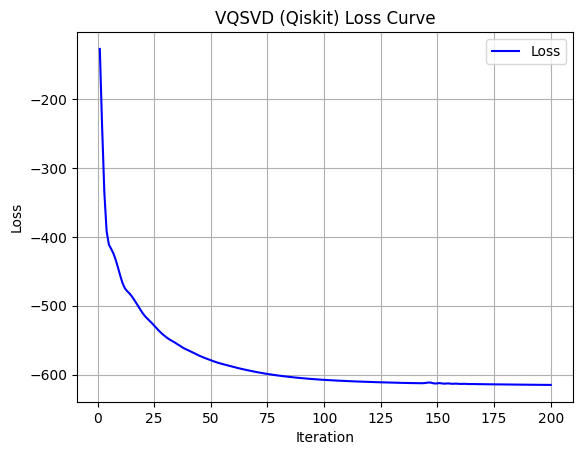

Singular value errors saved as ../results/qiskit_singular_value_comparasion.png


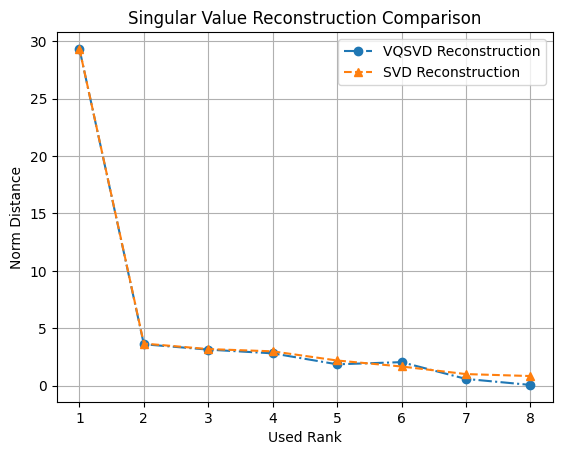

Reconstructed matrix image saved as ../results/qiskit_reconstruction_matrix.png


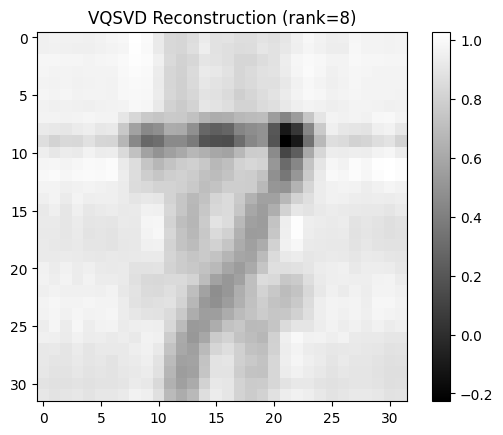

In [61]:
if __name__ == "__main__":
    # -------------------------------
    # 1) Hyperparameters
    # -------------------------------
    circuit_depth = 40
    num_qubits = 5
    rank = 8
    iterations = 200
    learning_rate = 0.02
    seed = 14

    weights = np.arange(2 * rank, 0, -2).astype(complex)

    # -------------------------------
    # 2) Load matrix from image
    # -------------------------------
    generator = MatrixGeneratorQiskit(num_qubits)
    matrix = generator.from_image("../figures/MNIST_32.png")
    matrix_copy = np.copy(matrix)

    # -------------------------------
    # 3) Initialize and train VQSVD
    # -------------------------------
    model = VQSVDQiskit(
        matrix=matrix,
        weights=weights,
        num_qubits=num_qubits,
        depth=circuit_depth,
        rank=rank,
        lr=learning_rate,
        iterations=iterations,
        seed=seed
    )

    print("Starting training… (this may take a while)")
    loss_history, svals_history = model.train_with_adam_numpy(n_jobs=10)
    print("Training completed.")

    U_final = model.get_U()
    Vh_final = model.get_V().conj().T

    # -------------------------------
    # 4) Plot loss curve
    # -------------------------------
    plotter = LossPlotQiskit(save_path="../results/")
    plotter.plot_loss_curve(loss_history)

    # -------------------------------
    # 5) Frobenius error analysis on random matrix
    # -------------------------------
    random_matrix = generator.generate_random_matrix()
    random_copy = np.copy(random_matrix)

    err_local, err_subfull, err_svd = model.frobenius_errors(
        M_true=random_matrix,
        M_approx=random_copy,
        U_learnt=U_final,
        svals_list=svals_history,
        V_dagger_learnt=Vh_final,
        rank=rank
    )

    svals_q = np.array(svals_history[-1], dtype=float)
    _, svals_exact, _ = np.linalg.svd(matrix)
    svals_exact = svals_exact[:rank]

    plotter.plot_singular_value_comparison(rank=rank, vqsvd=svals_q, svd=svals_exact)

    # -------------------------------
    # 6) Matrix reconstruction
    # -------------------------------
    last_svals = np.array(svals_history[-1], dtype=float)
    U_part = U_final.real[:, :rank]
    D_part = np.diag(last_svals[:rank])
    Vh_part = Vh_final.real[:rank, :]
    reconstructed = U_part @ D_part @ Vh_part

    plotter.plot_matrix_image(reconstructed, title=f"VQSVD Reconstruction (rank={rank})")
